# Intro to Spatial Data Science #sds4gdsp

## 0. Setup

In [1]:
import random
random.seed(2023) # for reproducibility
import leafmap # for visualizing maps
import osmnx as ox # for processing graph-like datasets
import networkx as nx # for processing graph-like datasets
import pandas as pd # for processing tabular data
pd.options.display.max_colwidth=200
pd.options.display.max_columns=100
import matplotlib.pyplot as plt
import geopandas as gpd # for processing geographic tables
from shapely.geometry import (
    Point, LineString, Polygon
) # for processing native geometries
from itertools import combinations

## 1. README

### a. Prework.

By this time around, you should already be comfortable in writing code using Python, installing different packages from PyPI, and using virtual environments (conda, venv, poetry, etc). Please execute the following steps in your local machine:

1. Clone the **sds4gdsp** github repository from this link
```git clone https://github.com/jpacil0/sds4gdsp.git```

2. Create a conda environment named **gdsenv** with **python=3.8.16**
```conda create --name gdsenv python=3.8.16```

3. Install **jupyterlab** in that environment, we will use this for the workshop
```pip install jupyterlab```

4. Install the packages from the **requirements.txt**, follow the **README.md**
```pip install -r requirements.txt```

5. Setup jupyter for rendering leaflet maps
```conda install -c conda-forge ipyleaflet``` <br>
```jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet```

### b. Learning Objectives.

This lecture provides DSP cadets with little-to-no prior knowledge core competences in Spatial Data Science (SDS).

1. Advancing their numerical, computational, and statistical literacy.

2. Introducing basic principles of programming and state-of-the-art (SOTA) computational tools for SDS.

3. Presenting a comprehensive overview of the main methodologies available to the Spatial Data Scientist, as well as their intuition as to how and when they can be applied.

4. Focusing on real world applications of these techniques in a geographical and applied context.

### c. Learning Outcomes.

By the end of the lecture & workshop, DSP students will be able to:

1. Demonstrate fundamental spatial data science concepts and be able to use the tools programmatically to import, manipulate and analyze spatial data in different formats.

2. Understand the motivation and inner workings of the main methodological approcahes of SDS, both analytical and visual.

3. Apply spatial analysis techniques and explain how to interpret the results, in a process of turning data into information.

## 2. What makes this subject so spatial?

### a. SDS aims to answer the twofold question - where and why things happen.

Spatial Data Science is interested in understanding both where certain things happen and why they happen in those places. To do this, Spatial Data Scientists leverage location, distance, and spatial interactions as core aspects of the data they work with and use highly specialized methods and cutting-edge software to analyze, visualize, and draw actionable insights from various spatial use cases. 

### b. SDS is the intersection of Data Science (DS) and Geographic Information System (GIS).

GIS is a niche field that refers to different types of information systems, such as websites, apps, or databases for storing and processing spatial datasets. Today, Spatial Data Scientists use GIS as part of a wider, more modern tech stack allowing them to do more advanced statistical- and modeling-based analyses while also being able to leverage the latest artificial intelligence and machine learning techniques more effectively.

### c. Only 1 in 3 Data Scientists claiming to be experts in spatial analysis.

Spatial Data Science is clearly still a niche area of data science, it is nonetheless an attractive area for organizations to explore and focus on in the years ahead. According to this survey, 9 in 10 of the industries surveyed (telco, software & tech, consulting, cities & government, etc.)
- have a difficult time finding, recruiting, and hiring talent with SDS in their toolbelt  
- are very likely to increase their investment in SDS for the next two years

## 3. How can I relate this to my work in Globe? 

### a. Geo-spatial data in the telco universe (even outside) is ubiquitous.

Here are some examples of geospatial data you can encounter in telco world.

*Point* representation

- Globe cellsites
- Globe fiber NAPs
- Globe physical stores
- Globe sub households
- Globe blitz deployments
- Globe OOH advertisements
- Building footprints

*Polygon* representation

- PH admin boundaries
- Globe cellsite coverage areas
- Globe fiber coverage areas
- Custom enumeration units (grids, hexagons, etc)
- Competitor coverage estimates

*Graph* representation

- PH road networks
- Globe fiber wiring connections
- WW internet submarine cabling

In [198]:
def make_geoms(n):
    coords = np.random.random((n, 2))
    points = list(map(lambda z: shapely.geometry.Point(z), coords))
    lines = shapely.geometry.LineString(points)
    lines = list(map(lambda x: shapely.geometry.LineString(x), list(zip(points, points[1:]))))
    polygon = Polygon(points)# .convex_hull
    return points, lines, polygon

def make_graph(
    origin, network_type, dist=500, dist_type="bbox", retain_all=False, simplify=True
):
    # query the road network using OSMNx
    G = ox.graph_from_point(
        center_point=origin, # origin point of query
        dist=dist, # radius in meters from the origin
        dist_type=dist_type, # examples is `bbox`
        retain_all=retain_all, # filter connected components?
        simplify=simplify, # simplify network topology
        network_type=network_type # filter to <insert type from OSM> roads
    )
    return G

<img src="../docs/imgs/cellsite.jpeg" alt="Drawing" style="width: 400px;"/>

In [203]:
n = 25
points, lines, polygon = make_geoms(n)

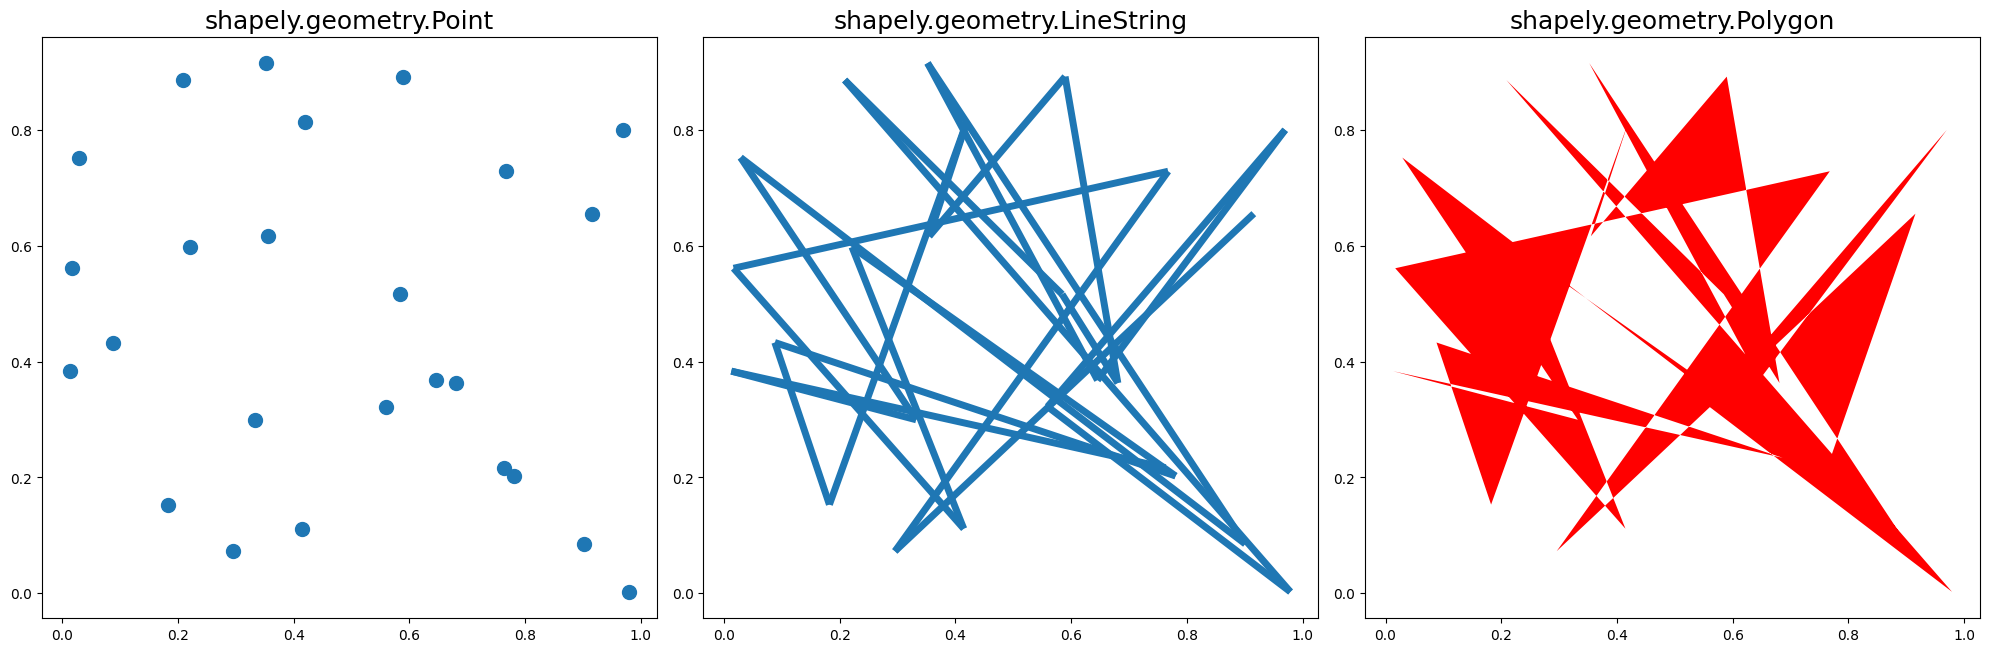

In [205]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
gpd.GeoSeries(points).plot(ax=ax[0], markersize=100)
gpd.GeoSeries(lines).plot(ax=ax[1], linewidth=5)
gpd.GeoSeries(polygon).plot(ax=ax[2], linewidth=5, color="red")
ax[0].set_title(f"shapely.geometry.Point", fontsize=18)
ax[1].set_title(f"shapely.geometry.LineString", fontsize=18)
ax[2].set_title(f"shapely.geometry.Polygon", fontsize=18)
plt.tight_layout();

In [201]:
# the globe tower @ bgc taguig
COORD_TGT = (14.553514, 121.050110)
G_drive = make_graph(origin=COORD_TGT, network_type="drive")
G_walk = make_graph(origin=COORD_TGT, network_type="walk")
G_bike = make_graph(origin=COORD_TGT, network_type="bike")

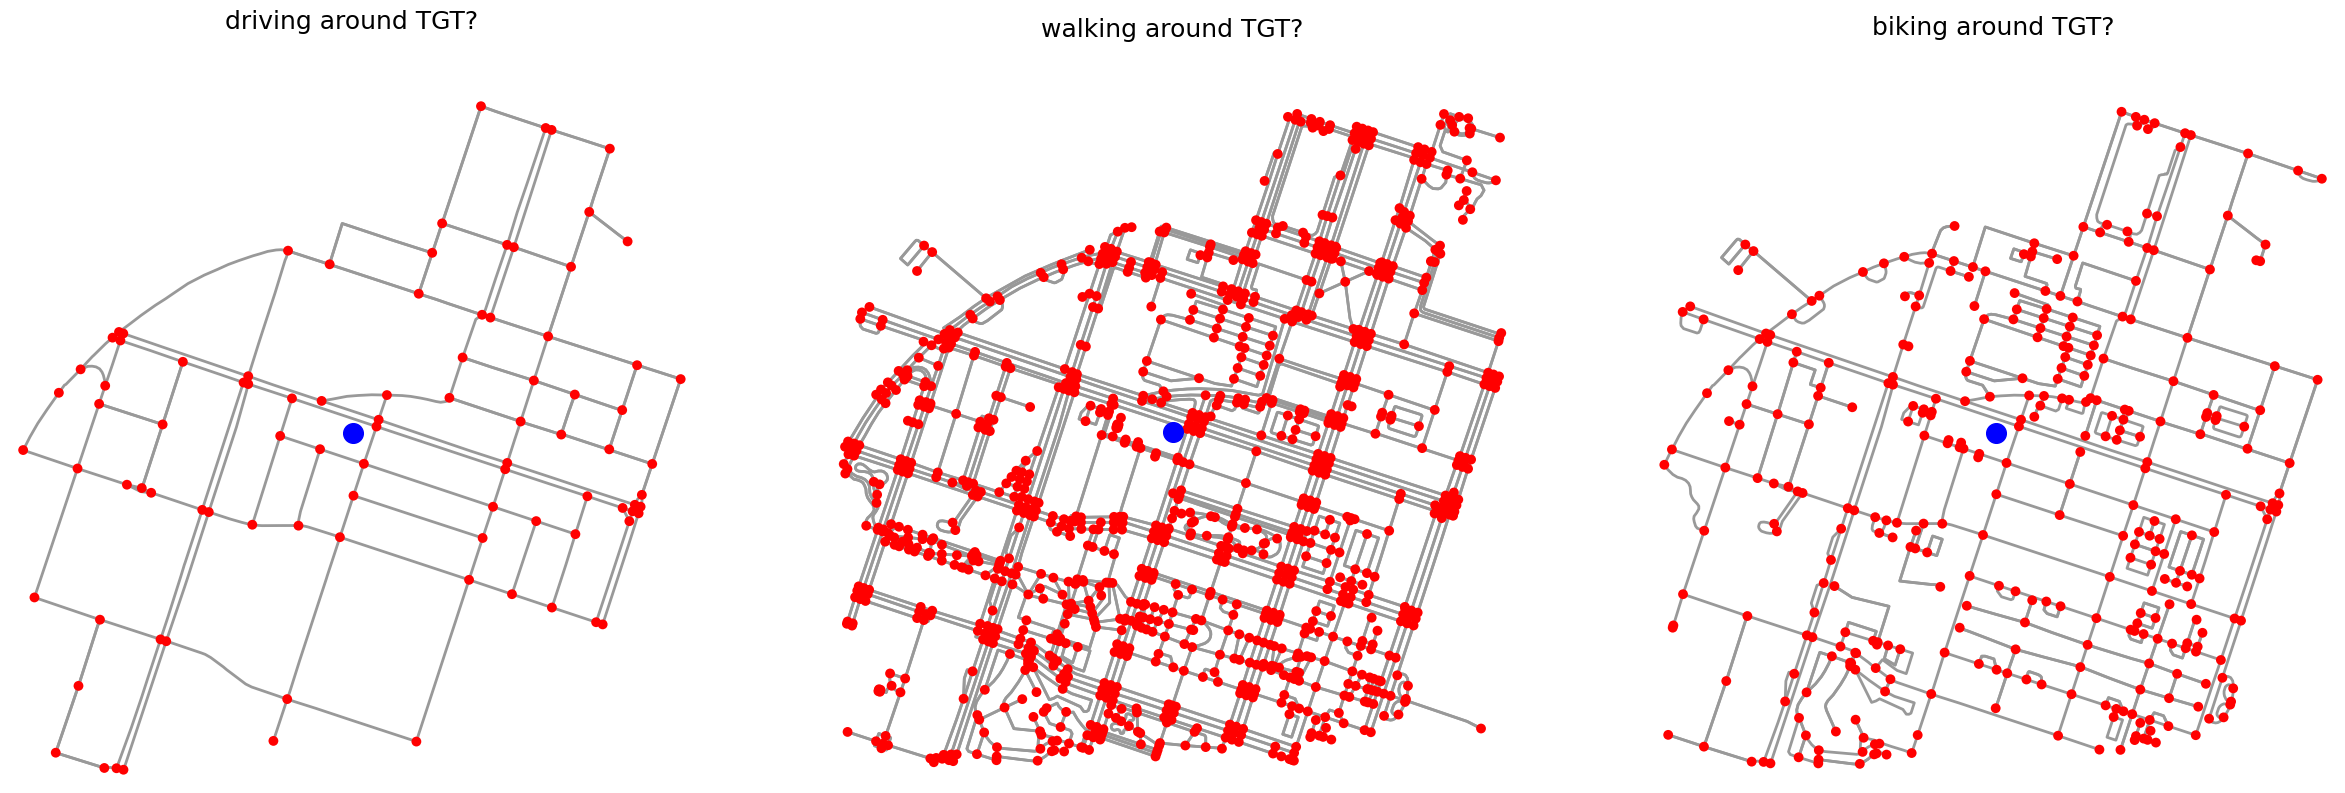

In [202]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ox.plot_graph(G=G_drive, ax=ax[0], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ox.plot_graph(G=G_walk, ax=ax[1], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ox.plot_graph(G=G_bike, ax=ax[2], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ax[0].set_title("driving around TGT?\n\n", fontsize=18)
ax[1].set_title("walking around TGT?\n\n", fontsize=18)
ax[2].set_title("biking around TGT?\n\n", fontsize=18)
ax[0].scatter(*COORD_TGT[::-1], c="blue", s=200)
ax[1].scatter(*COORD_TGT[::-1], c="blue", s=200)
ax[2].scatter(*COORD_TGT[::-1], c="blue", s=200);

## 4. Dev notes and programming hacks

## 5. References

1. https://carto.com/what-is-spatial-data-science